In [1]:
import pandas as pd
from sclibrary.simplicial_complex import SimplicialComplexNetwork

In [8]:
data_folder = 'data/sample_data'

B1 = pd.read_csv(data_folder + '/B1.csv', header=None)
print(B1.shape)
B1

(5, 7)


,0,1,2,3,4,5,6
0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,-1.0,-1.0,-1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,-1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,-1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [9]:
B2 = pd.read_csv(data_folder + '/B2.csv', header=None)
print(B2.shape)
B2

(2, 7)


,0,1,2,3,4,5,6
0,0.0,0.0,1.0,-1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,-1.0,0.0,1.0


In [10]:
from sclibrary.read_incidence_matrix import ReadIncidenceMatrix

data = ReadIncidenceMatrix(B1, B2)
data.get_data_summary()
print("Nodes", data.get_nodes())
print("Edges", data.get_edge_list(rank=1))
print("Triangle Edges", data.get_edge_list(rank=2))
print("Adjacency", data.get_adjacency_matrix())
#graph = data.creat_nx_graph()
#data.draw_graph()

number of nodes:  5
number of edges:  7
number of triangles:  2
Nodes [0, 1, 2, 3, 4]
Edges [(0, 1), (0, 2), (1, 2), (1, 3), (1, 4), (2, 3), (3, 4)]
Triangle Edges [[1, 2, 3], [1, 3, 4]]
Adjacency [[ 0 -1 -1  0  0]
 [ 1  0 -1 -1 -1]
 [ 1  1  0 -1  0]
 [ 0  1  1  0 -1]
 [ 0  1  0  1  0]]


In [5]:
pos = pd.read_csv(data_folder + '/coordinate.csv', header=None)
pos = pos.T

# create into a dict
pos_dict = {}
for i in range(pos.shape[0]):
    pos_dict[i] = (pos.iloc[i, 0], pos.iloc[i, 1])
    
pos_dict

(2642, 2)

[(0, 1), (0, 2), (1, 2), (1, 3), (1, 4), (2, 3), (3, 4), [1, 2, 3], [1, 3, 4]]


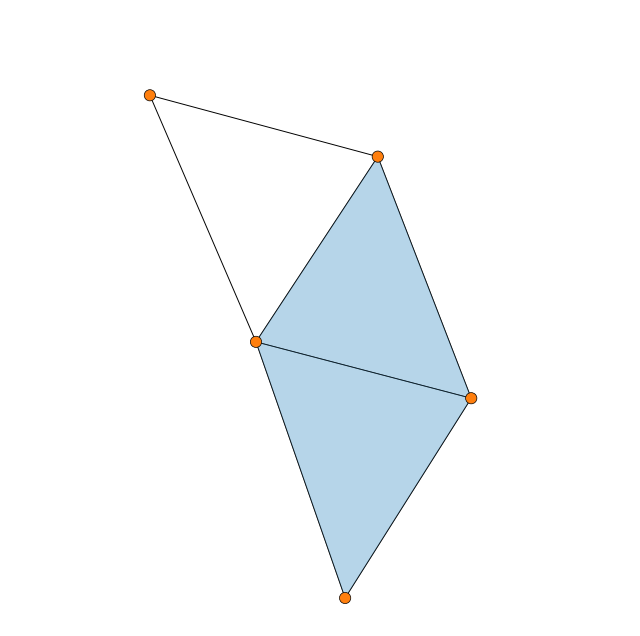

In [18]:
edges = data.get_edge_list()
print(edges)
sc = SimplicialComplexNetwork(edges, pos=None)
sc.draw_2d()